## Collision élastique de deux disques

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.display import Image, HTML

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure, curdoc
from bokeh.models import Arrow, OpenHead, NormalHead, VeeHead, ColumnDataSource, Select, TextInput
from bokeh.layouts import widgetbox
from bokeh.models.widgets import Slider

output_notebook()

Loading BokehJS ...

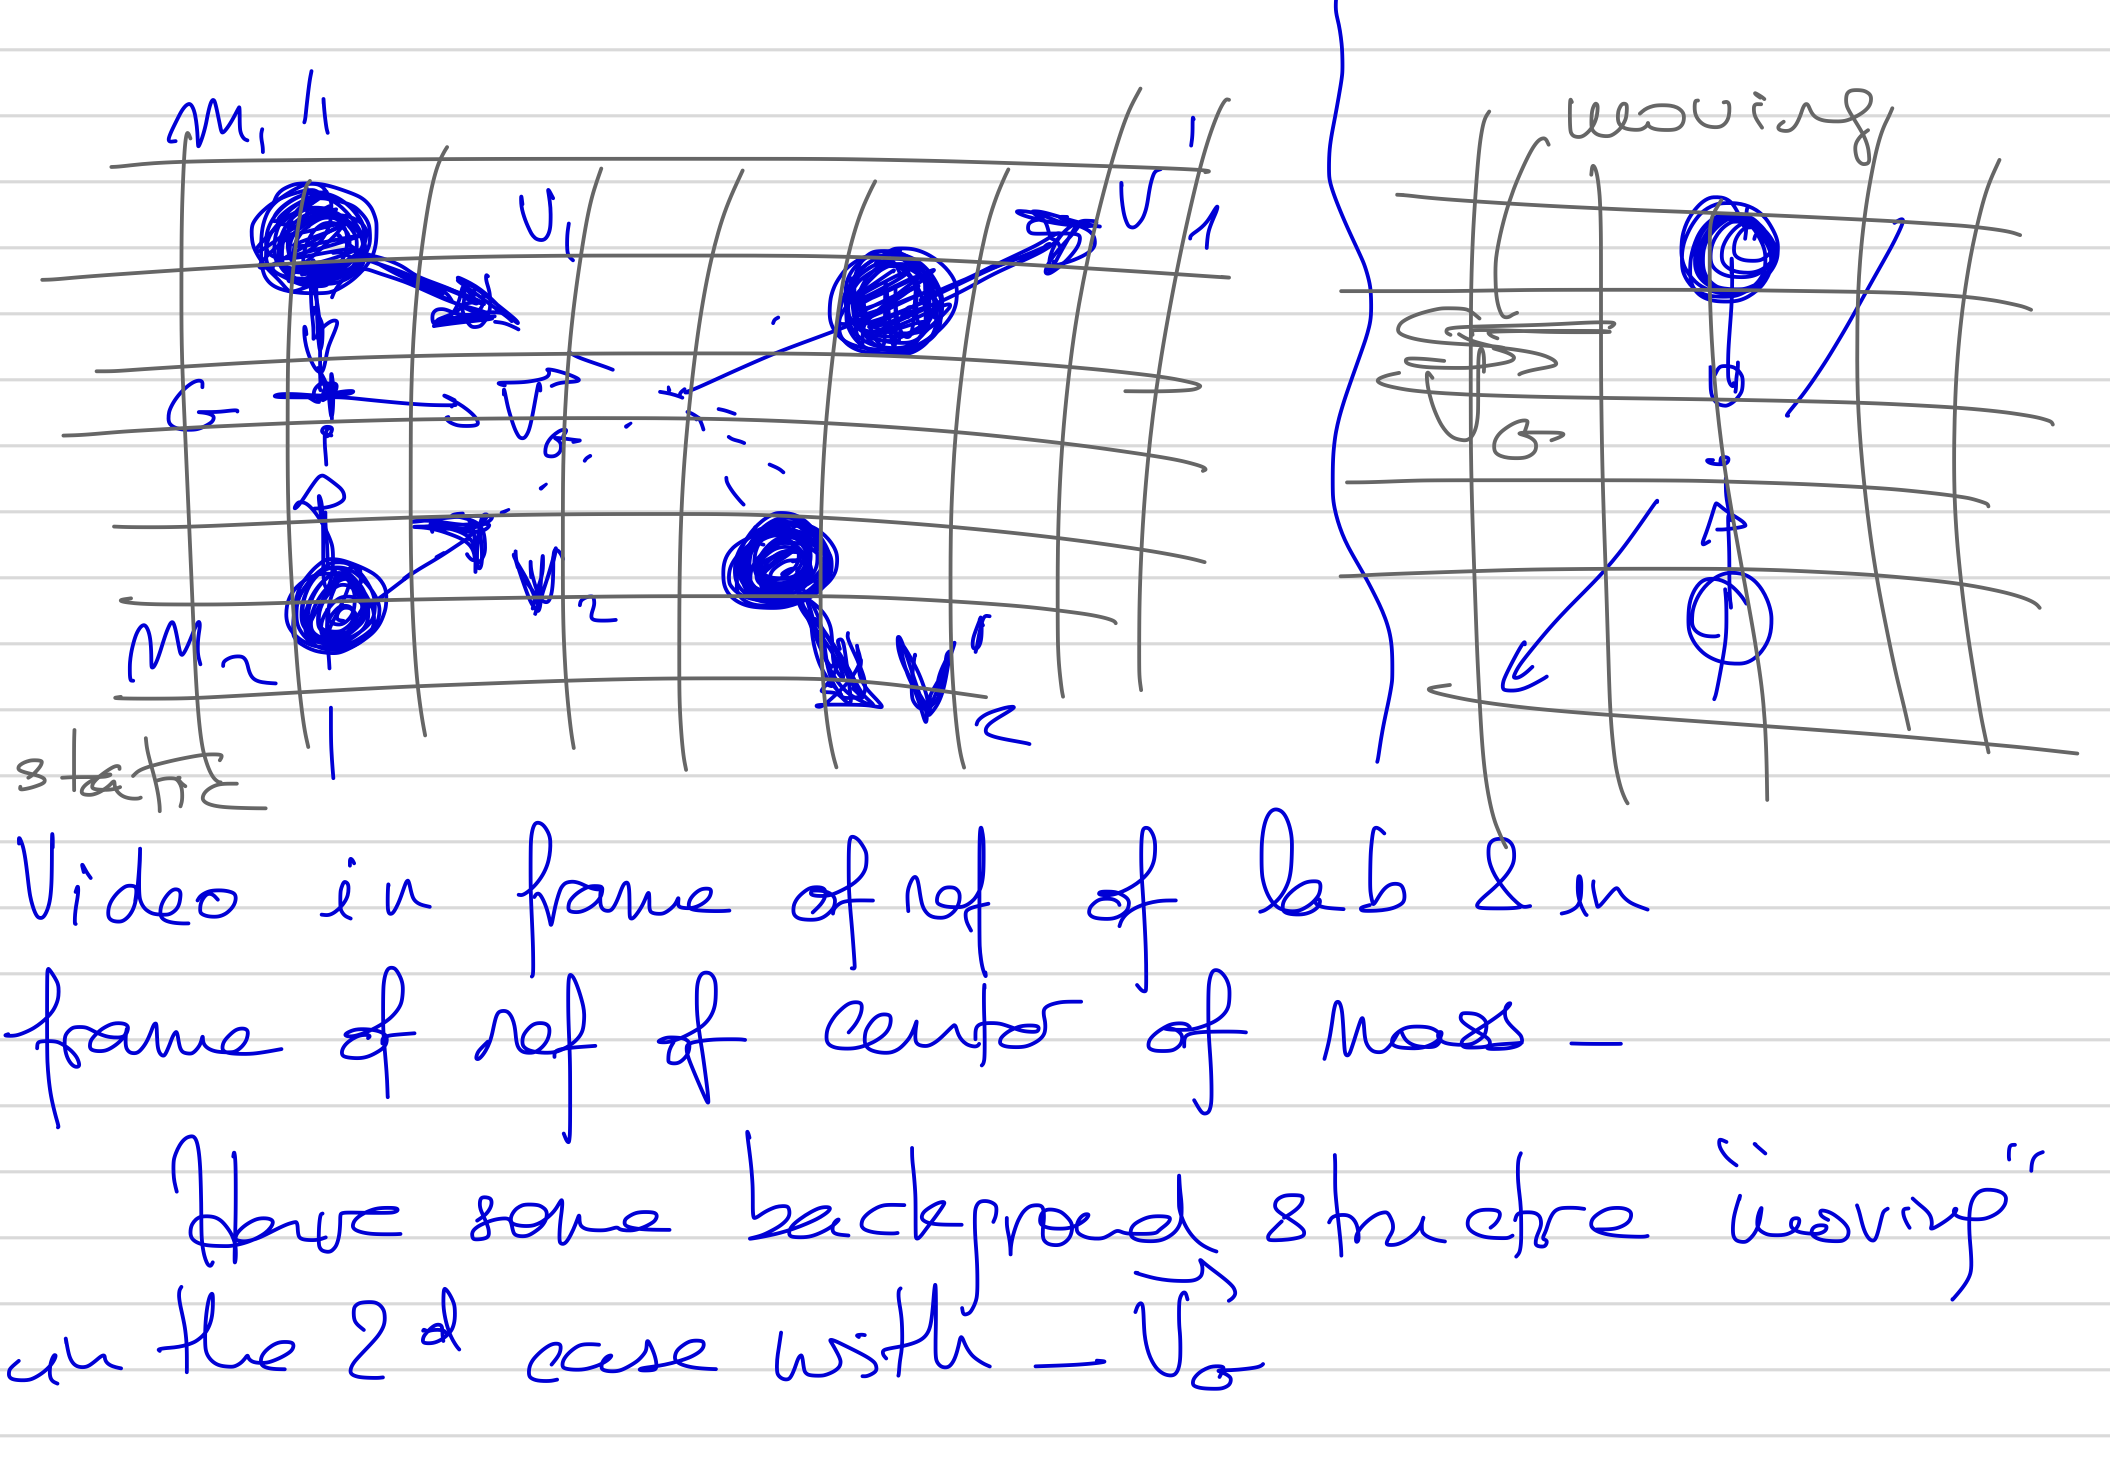

In [2]:
Image("elastic_coll.png")

In [2]:
# fonction calcul de la masse
mass = lambda P : (4 / 3) * P['density'] * np.pi * P['radius'] ** 3

vel_ = lambda P: (P['v']*np.cos(P['alpha']*np.pi/180), P['v']*np.sin(P['alpha']*np.pi/180))

traj_ = lambda P:  [P['x'] + P['v_x']*np.linspace(0, 500, 500)/10, P['y'] + P['v_y']*np.linspace(0, 500, 500)/10]

new_ = lambda P, dt: (P['x'] + P['v_x']*dt, P['y'] + P['v_y']*dt)

dist_ = lambda P1, P2: math.sqrt((P1['x'] - P2['x'])**2 + (P1['y'] - P2['y'])**2)

proj_v = lambda P, w: (P['v_x']*w[0] + P['v_y']*w[1])/(np.linalg.norm(w))**2

proj_v_vec = lambda P, w: proj_v(P,w)*w

e_cinetique = lambda P1, P2: P1['m']*P1['v']**2 + P2['m']*P2['v']**2

quant_mov_u = lambda P1, P2, u: P1['m']*proj_v(P1, u) + P2['m']*proj_v(P2,u)

#new_v_coll = lambda P, w, u: (proj_v(P,w) + (np.array([P['v_x'], P['v_y']]) - proj_v(P,u)))
new_v_coll = lambda P, w, u: (proj_v_vec(P,w) - proj_v_vec(P,u))

In [3]:

def update_values_time(P1, P2, dt):
    t = 0
    P1['traj'] = [(P1['x'], P1['y'])]
    P2['traj'] = [(P2['x'], P2['y'])]
    
    P1['init_x'] = P1['x']
    P1['init_y'] = P1['y']
    P2['init_x'] = P2['x']
    P2['init_y'] = P2['y']
    
    while t < min(P1['t'], P2['t']):
        
        # calculer prochain possition
        P1['x'], P1['y'] = new_(P1, dt)
        P2['x'], P2['y'] = new_(P2, dt)
        P1['traj'].append((P1['x'], P1['y']))
        P2['traj'].append((P2['x'], P2['y']))

        # verifier si il y haura une collision
        if dist_(P1, P2) < (P1['radius'] + P2['radius']) + 0.01:            

            # calculer vecteur perpendiculaire à la collision
            u = np.array([P2['x'] - P1['x'], P2['y'] - P1['y']])/dist_(P1,P2)

            # point collision
            p_x = P1['x'] + u[0]*P1['radius']/dist_(P1,P2)
            p_y = P1['y'] + u[1]*P1['radius']/dist_(P1,P2)

            # vecteur tangent à la collision
            w = np.array([u[1], -u[0]])

            # mettre à jour velocité après collision
            P1['v_x'], P1['v_y'] = new_v_coll(P1, w, u)
            P2['v_x'], P2['v_y'] = new_v_coll(P2, w, u)

            P1['v'] = math.sqrt(P1['v_x']**2 + P1['v_y']**2)
            P2['v'] = math.sqrt(P2['v_x']**2 + P2['v_y']**2)

        t += dt  
    
    P1['traj'] = np.array(P1['traj'])
    P2['traj'] = np.array(P2['traj'])


def update_params(P, P_y, P_radius, v_P, alpha_P):
    P['y'] = P_y
    P['v'] = v_P
    
    if P['name'] == 'A':
        P['alpha'] = alpha_P -90
    else:
        P['alpha'] = alpha_P + 90
    
    P['radius'] = P_radius
    P['m'] = mass(P)
    P['v_x'], P['v_y'] = vel_(P)
    #P['traj'] = traj_(P)

def convert_to_array(P):
    for k in ['x', 'init_x', 'y', 'init_y']:
        P[k] = np.array(P[k])

    

# Initialize
def initialize(t, x_a, x_b, y_a, y_b, v_a, v_b, alpha_a, alpha_b, rad_a, rad_b):
    A = {'x':x_a, 'y': y_a, 'v':v_a, 'alpha': alpha_a, 'density': 1, 'radius': rad_a, 't':t, 'name':'A'}
    B = {'x':x_b, 'y': y_b, 'v':v_b, 'alpha': alpha_b, 'density': 1, 'radius': rad_b, 't':t, 'name':'B'}


    A['v_x'], A['v_y'] = vel_(A) 
    B['v_x'], B['v_y'] = vel_(B) 

    A['m'], B['m'] = mass(A), mass(B)
    
    return A,B


In [26]:
global T, x_a, x_b

T = 50
x_a = -250
x_b = 250



A, B = initialize(T, x_a, x_b, 0.5, 0, 10, 15, 180, 0, 5, 3) #t, x_a, x_b, y_a, y_b, v_a, v_b, alpha_a, alpha_b, rad_a, rad_b
update_values_time(A, B, 0.2)

p = figure(title="Collision", plot_height=450, plot_width=900, y_range=(min(min(A['traj'][:,1]), min(B['traj'][:,1])) - 100, max(max(A['traj'][:,1]), max(B['traj'][:,1])) + 100), 
           x_range=(min(min(A['traj'][:,0]), min(B['traj'][:,0])) -100, max(max(A['traj'][:,0]), max(B['traj'][:,0])) +100), 
           background_fill_color='#ffffff')

# grille
p.ygrid.minor_grid_line_color = 'grey'
p.ygrid.minor_grid_line_alpha = 0.3

p.xgrid.minor_grid_line_color = 'grey'
p.xgrid.minor_grid_line_alpha = 0.3


source_A = ColumnDataSource(data= {'x_t': A['traj'][:,0], 'y_t': A['traj'][:,1]})
source_B = ColumnDataSource(data= {'x_t': B['traj'][:,0], 'y_t': B['traj'][:,1]})

P_A = p.circle(x=A['init_x'], y=A['init_y'], size=A['radius'], fill_color='#e32020', line_color='#e32020', legend=A['name'])
P_B = p.circle(x=B['init_x'], y=B['init_y'], size=B['radius'], fill_color='#0ABDE3', line_color='#0ABDE3', legend=B['name'])

g_pA = P_A.glyph
g_pB = P_B.glyph

#p.circle(x='init_x', y='init_y', source=source_A, size=2, fill_color='#000000', line_color='#000000')
#p.circle(x='init_x', y='init_y', source=source_B, size=2, fill_color='#000000', line_color='#000000')

Traj_A = p.line(x=A['traj'][:,0], y=A['traj'][:,1], color='#e32020')
Traj_B = p.line(x=B['traj'][:,0], y=B['traj'][:,0], color='#0ABDE3')


def update(A_y, B_y, A_radius, B_radius, v_A, v_B, alpha_A, alpha_B):
    
    A, B = initialize(T, x_a, x_b, A_y, B_y, v_A, v_B, alpha_A, alpha_B, A_radius, B_radius)
    update_values_time(A, B, 0.1)
    
    source_A = ColumnDataSource(data= {'x_t': A['traj'][:,0], 'y_t': A['traj'][:,1]})
    source_B = ColumnDataSource(data= {'x_t': B['traj'][:,0], 'y_t': B['traj'][:,1]})

    # mettre à jour radius
    g_pA.size = A['radius']
    g_pB.size = B['radius']
    
    
    # mettre à jour position
    g_pA.y = A_y
    g_pB.y = B_y
    
    # mettre à jour trajectoire
    Traj_A.data_source.data['x'] = source_A.data['x_t']
    Traj_A.data_source.data['y'] = source_A.data['y_t']
    Traj_B.data_source.data['x'] = source_B.data['x_t']
    Traj_B.data_source.data['y'] = source_B.data['y_t']
    
    print('Masse point A: {:0.2f} kg'.format(A['m']/1000))
    print('Masse point B: {:0.2f} kg'.format(B['m']/1000))
    
    push_notebook()
    
slider_Ay = widgets.IntSlider(min=-90, max=90, step=5, value=0, description='$A_{y} [m]$:')
slider_By = widgets.IntSlider(min=-90, max=90, step=5, value=0, description='$B_{y} [m]$:')

slider_Ar = widgets.FloatSlider(min=5,max=50,step=1,value=10, description='$A_{radius} [m]$:')
slider_Br = widgets.FloatSlider(min=5,max=50,step=1,value=10, description='$B_{radius} [m]$:')

slider_Av = widgets.FloatSlider(min=2,max=50,step=1,value=10, description='$v_{A} [m/s]$:')
slider_Bv = widgets.FloatSlider(min=2,max=50,step=1,value=15, description='$v_{B} [m/s]$:')

slider_A_alpha = widgets.FloatSlider(min=0,max=180,step=1,value=0, description='$ alpha A [º]$:')
slider_B_alpha = widgets.FloatSlider(min=0,max=180,step=1,value=0, description='$ alpha B [º]$:')
    

show(p, notebook_handle=True)
interact(update, A_y = slider_Ay, B_y = slider_By, A_radius = slider_Ar, B_radius = slider_Br,\
        v_A = slider_Av, v_B = slider_Bv, alpha_A = slider_A_alpha, alpha_B = slider_B_alpha);




interactive(children=(IntSlider(value=0, description='$A_{y} [m]$:', max=90, min=-90, step=5), IntSlider(value…

In [ ]:
# TODO: 

# GENERATE VIDEO FROM INITIAL CONF GOT FROM THE INTERACTIVE PLOT
# GENERATE WITH FUNCTION UPDATE_VALUES_TIME BY ITERATING UNTIL T<= 0
# SHOULD IT CHECK COLLISIONS AGAINST WALLS?
